## Load some libraries

In [9]:
import os
from pystac_client import Client as pystacclient
from odc import stac as odc_stac
from odc.geo import geobox
import datetime
import dask
from dask.distributed import Client

## <a id='startup'></a> Let's start with some relevant settings

To identify the relevant STAC collection, visit [terrabyte STAC Browser ](https://stac.terrabyte.lrz.de/browser/) with your browser.


In [2]:
stacUrl = "https://stac.terrabyte.lrz.de/public/api" # currently working STAC API endpoint
collection = ["modis-13a2-061"] 
bbox = [11.2, 47.5, 11.5, 48] 
date = ["2020-01-01", "2020-12-31"]

## Search the STAC API

We will open the terrabyte STAC API catalog...

In [3]:
catalog = pystacclient.open(
    url=stacUrl
)

... and donduct a search query

In [12]:
stac_items = catalog.search(
    collections=collection, 
    datetime=date,
    bbox=bbox,
    query={
        "platform": dict(eq="terra"),
        #"modis:vertical-tile": dict(eq="4")
    }
).item_collection()

print(f"Found {len(stac_items):d} MOD13A3 datasets with platform = terra, in the given bounding box and in the date range between 2020-01-01 and 2020-12-31")

Found 24 MOD13A3 datasets with platform = terra, in the given bounding box and in the date range between 2020-01-01 and 2020-12-31


## Let's have a look at the first STAC item in the list

In [13]:
stac_items[0]

<Item id=MOD13A2.A2020353.h18v04.061>

## Define and start Dask client

In [14]:
dir_out = '~/xarray-dask-tutorial'
dask_tmpdir = os.path.join(dir_out, 'scratch', 'localCluster')
dask_chunksize = 1200
# from testins running without threads is the faster option 
dask_threads = 1

In [15]:
host = os.getenv('host')
jl_port = os.getenv('port')
#create to URL to point to the jupyter-server-proxy
dask_url = f'https://portal.terrabyte.lrz.de/node/{host}/{jl_port}'+'/proxy/{port}/status'
#dask will insert the final port choosen by the Cluster 

dask.config.set({'temporary_directory': dask_tmpdir,
                 'distributed.dashboard.link': dask_url})

#some settings to increase network timeouts and allow the dashboard to plot larger graphs
dask.config.set({'distributed.comm.timeouts.tcp': '180s',
                 'distributed.comm.timeouts.connect': '120s',
                 'distributed.dashboard.graph-max-items': 55000,
                 'distributed.deploy.lost-worker-timeout': '90s',
                 'distributed.scheduler.allowed-failures': 180,
                 })
#we set the dashboard address for dask to choose a free random port, so there is no error with multiple dasks running on same node 
client = Client(threads_per_worker=dask_threads, dashboard_address="127.0.0.1:0")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar03c06s08.cos.lrz.de/5696/proxy/33815/status,
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar03c06s08.cos.lrz.de/5696/proxy/33815/status,Workers: 16
Total threads: 16,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42945,Workers: 16
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar03c06s08.cos.lrz.de/5696/proxy/33815/status,Total threads: 16
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:42117,Total threads: 1
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar03c06s08.cos.lrz.de/5696/proxy/37369/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:37815,


## Let's load the data...

In [10]:
cube = odc_stac.load(stac_items,
                     chunks={'x': dask_chunksize, 'y': dask_chunksize},  # spatial chunking
                     anchor=geobox.AnchorEnum.FLOATING  # preserve original pixel grid
)
cube

<xarray.Dataset>
Dimensions:                    (y: 1200, x: 1200, time: 24)
Coordinates:
  * y                          (y) float64 5.559e+06 5.558e+06 ... 4.448e+06
  * x                          (x) float64 463.3 1.39e+03 ... 1.111e+06
    spatial_ref                int32 0
  * time                       (time) datetime64[ns] 2019-12-19 ... 2020-12-18
Data variables: (12/13)
    EVI                        (time, y, x) int16 dask.array<chunksize=(1, 1200, 1200), meta=np.ndarray>
    hdf                        (time, y, x) float32 dask.array<chunksize=(1, 1200, 1200), meta=np.ndarray>
    NDVI                       (time, y, x) int16 dask.array<chunksize=(1, 1200, 1200), meta=np.ndarray>
    VI_Quality                 (time, y, x) uint16 dask.array<chunksize=(1, 1200, 1200), meta=np.ndarray>
    MIR_reflectance            (time, y, x) int16 dask.array<chunksize=(1, 1200, 1200), meta=np.ndarray>
    NIR_reflectance            (time, y, x) int16 dask.array<chunksize=(1, 1200, 1200), meta=np.ndarray>
    ...                         ...
    blue_reflectance           (time, y, x) int16 dask.array<chunksize=(1, 1200, 1200), meta=np.ndarray>
    sun_zenith_angle           (time, y, x) int16 dask.array<chunksize=(1, 1200, 1200), meta=np.ndarray>
    pixel_reliability          (time, y, x) int8 dask.array<chunksize=(1, 1200, 1200), meta=np.ndarray>
    view_zenith_angle          (time, y, x) int16 dask.array<chunksize=(1, 1200, 1200), meta=np.ndarray>
    relative_azimuth_angle     (time, y, x) int16 dask.array<chunksize=(1, 1200, 1200), meta=np.ndarray>
    composite_day_of_the_year  (time, y, x) int16 dask.array<chunksize=(1, 1200, 1200), meta=np.ndarray>

## ... and plot the NDVI time-series

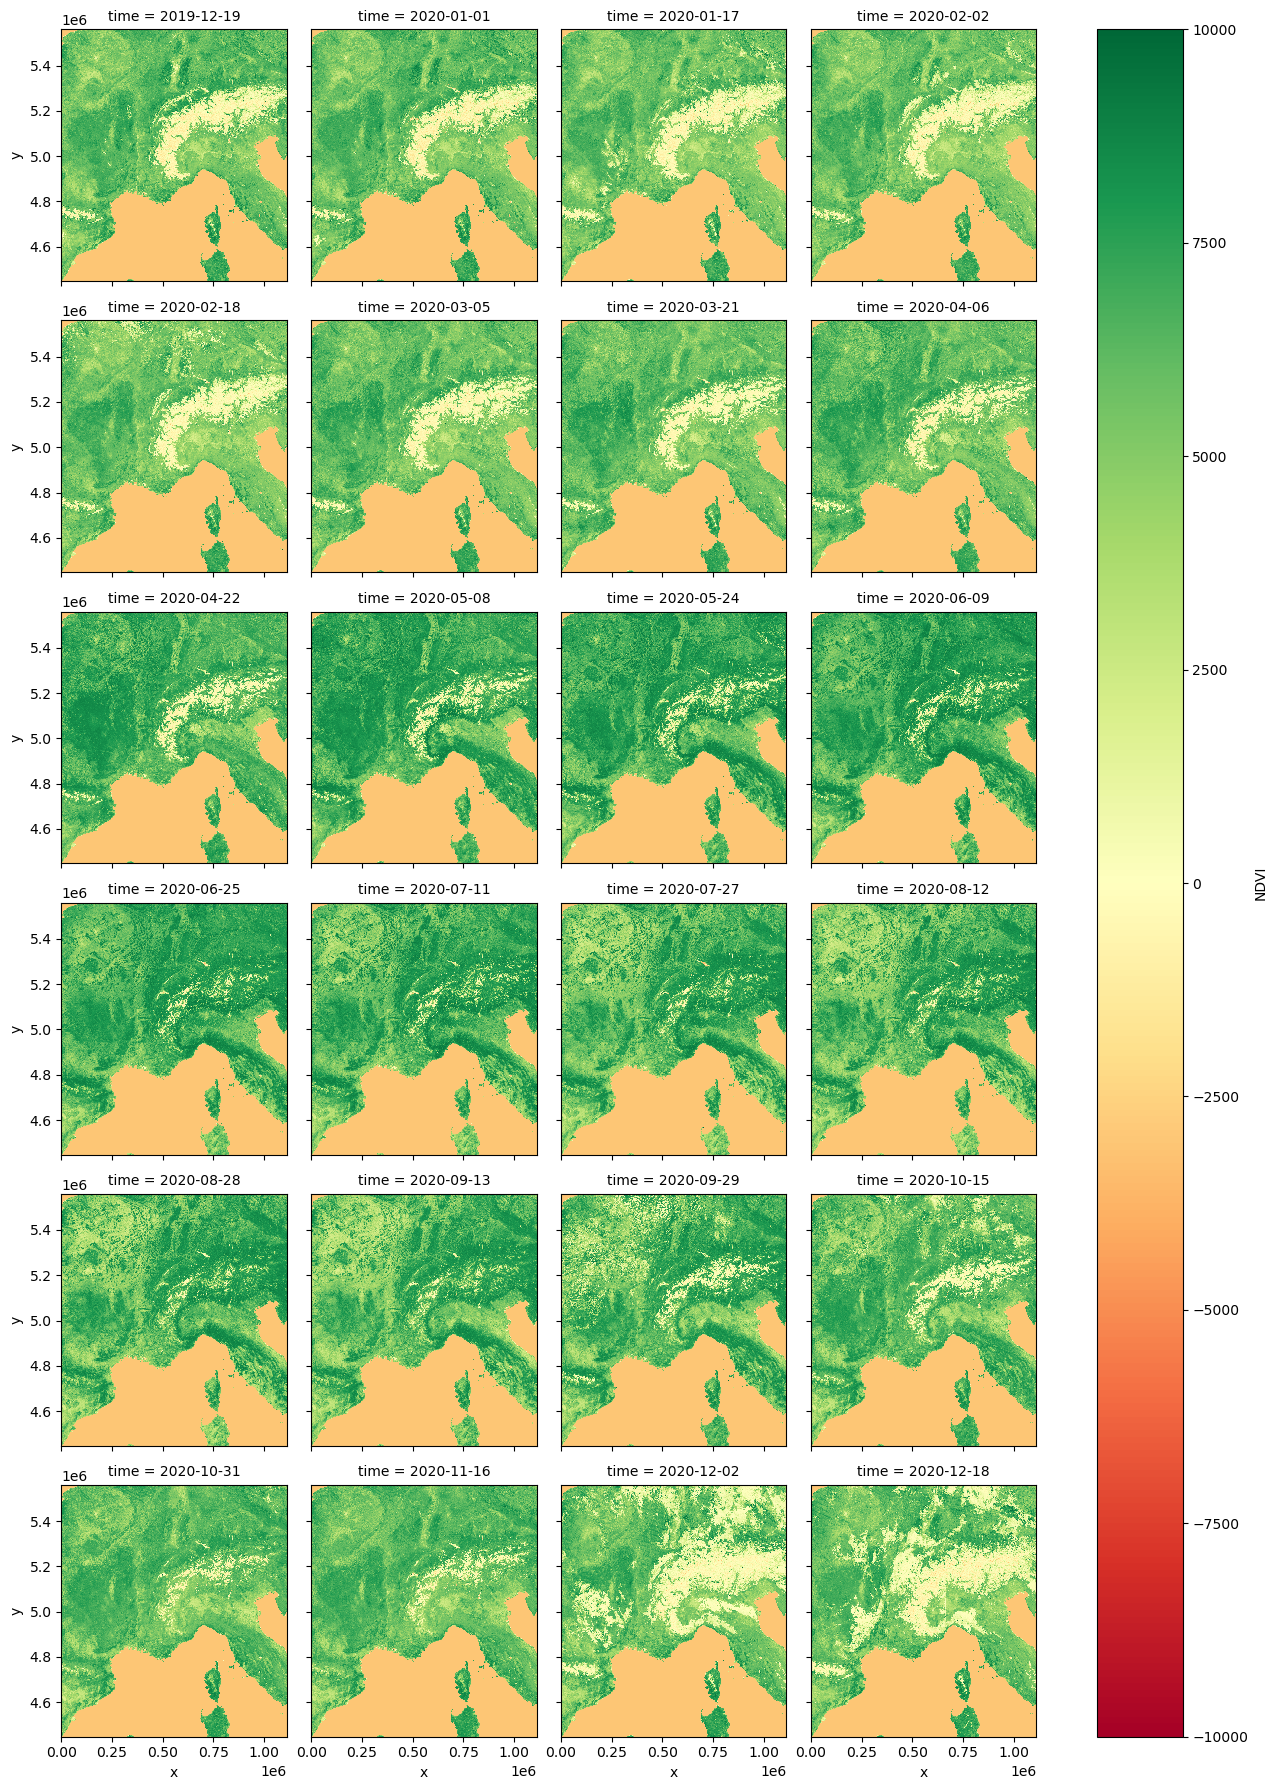

In [11]:
cube['NDVI'].plot.imshow(cmap="RdYlGn", col="time", col_wrap=4);

## Close Dask client

In [ ]:
client.close()